In [1]:
import xarray as xr
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import metpy
import cartopy.crs as ccrs
from pyresample import geometry, grid
import netCDF4

/sharedData2/nshakoor/.conda/envs/fires/lib/python3.7/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [3]:
path = '../../GOES_Files/nc_files/'
data = xr.open_dataset(path + random.choice(os.listdir(path)))

In [5]:
data

<xarray.Dataset>
Dimensions:                                           (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_sunglint_angle_bounds: 2, number_of_time_bounds: 2, x: 2500, y: 1500)
Coordinates:
    t                                                 datetime64[ns] 2020-08-...
  * y                                                 (y) float32 0.1282 ... ...
  * x                                                 (x) float32 -0.06997 .....
    y_image                                           float32 0.08624
    x_image                                           float32 0.0
    sunglint_angle                                    float32 10.0
    local_zenith_angle                                float32 80.0
    solar_zenith_angle                                float32 10.0
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_sunglint_angle_bounds, number_of_time_bounds
Data variables:
    Area                                              (y, x) float32 ...
    Temp                                              (y, x) float32 ...
    Mask                                              (y, x) float32 ...
    Power                                             (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 -2147483647
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                    float64 0.0
    nominal_satellite_subpoint_lon                    float64 -137.2
    nominal_satellite_height                          float64 3.579e+04
    geospatial_lat_lon_extent                         float32 9.969e+36
    sunglint_angle_bounds                             (number_of_sunglint_angle_bounds) float32 ...
    local_zenith_angle_bounds                         (number_of_LZA_bounds) float32 ...
    solar_zenith_angle_bounds                         (number_of_SZA_bounds) float32 ...
    total_number_of_pixels_with_fires_detected        float64 564.0
    total_number_of_pixels_with_fire_temperature      float64 260.0
    total_number_of_pixels_with_fire_area             float64 260.0
    total_number_of_pixels_with_fire_radiative_power  float64 304.0
    fire_temperature_outlier_pixel_count              float64 0.0
    fire_area_outlier_pixel_count                     float64 260.0
    fire_radiative_power_outlier_pixel_count          float64 0.0
    minimum_fire_temperature                          float64 402.7
    maximum_fire_temperature                          float64 2.232e+03
    mean_fire_temperature                             float64 688.4
    standard_deviation_fire_temperature               float64 249.6
    minimum_fire_area                                 float64 663.8
    maximum_fire_area                                 float64 5.707e+05
    mean_fire_area                                    float64 6.205e+04
    standard_deviation_fire_area                      float64 6.32e+04
    minimum_fire_radiative_power                      float64 19.25
    maximum_fire_radiative_power                      float64 3.963e+03
    mean_fire_radiative_power                         float64 439.5
    standard_deviation_fire_radiative_power           float64 514.2
    algorithm_dynamic_input_data_container            int32 -2147483647
    processing_parm_version_container                 int32 -2147483647
    algorithm_product_version_container               int32 -2147483647
    percent_uncorrectable_GRB_errors                  float64 0.0
    percent_uncorrectable_L0_errors                   float64 0.0
Attributes:
    naming_authority:          gov.nesdis.noaa
    Conventions:    

In [2]:
def find_npy_file(path, file, band):
    """
    Returns the string name of another file from the same time for a given GOES band npy file,
    or None if there is no such file in the given directory.
    
    Parameter path: The path where the returned file is located in
    Precondition: path is a string to a directory relative to the current one, with .npy files
    
    Parameter file: A file from the same time the returned file should have
    Precondition: file is a string with the name of the original file, and includes the path
    
    Parameter band: GOES band the returned file should be from
    Precondition: band is a string of length 2
    """
    for x in os.listdir(path):
        if x[19:21] == band and file[23:37] == x[27:41]:
            return x

def date(filename):
    date = datetime.datetime.strptime(filename[23:30], '%Y%j').date()
    return date.strftime('%m/%d/%Y')

def fire_mask(img07, img14):
    m = (330-210)/(340-295)
    b = 210 - m*295
    return (img14) < (m*img07 + b)

filedates = set()
files = []

for file in os.listdir('../../GOES_Files/npy_files'):
    filedates.add(file[27:41])

for file in os.listdir('../../GOES_Files/clear_sky_mask'):
    if file[23:37] in filedates:
        files.append(file)

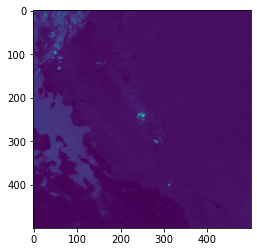

In [5]:
cont = 1
path = '../../GOES_Files/npy_files/'

while cont == 1:
    CM = random.choice(files)
    files.remove(CM)

    file07 = find_npy_file(path, CM, '07')
    file14 = find_npy_file(path, CM, '14')
    img07 = np.load(path + file07)
    img14 = np.load(path + file14)

    cloud_mask = np.load('../../GOES_Files/clear_sky_mask/' + CM)
    cloud_mask = cloud_mask.astype(bool)
    fires = np.logical_and(fire_mask(img07, img14), np.logical_not(cloud_mask))

    if np.count_nonzero(fires) != 0:
        cont = 0

diff = img07 - img14
plt.imshow(diff)
# plt.colorbar() 

plt.show()
plt.close()

In [63]:
CM

'OR_ABI-L2-ACMC-M6_G17_s20202321846176_e20202321848549_c20202321849247.npy'

In [6]:
pc = ccrs.PlateCarree() #equidistant cylindrical projection
pc_extents = [-124.25, -114.25, 32.25, 42.25] #lons, lats
pc_params = pc.proj4_params #projection parameters loaded from proj4
target_extents = [pc_extents[0], pc_extents[2], pc_extents[1], pc_extents[3]] #reorder the lons and lats
target_rows, target_cols = 500, 500
shape = [target_rows, target_cols] #shape of the image is 500x500 pixels

In [7]:
firefile = random.choice(os.listdir('../../GOES_Files/nc_files/'))
data = xr.open_dataset('../../GOES_Files/nc_files/' + firefile) 
dat = data.metpy.parse_cf('Mask')
bcm = dat.data

source_area = geometry.AreaDefinition.from_cf(data)
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, target_extents)

result = grid.get_resampled_image(target_area, source_area, bcm)
# np.save('../../GOES_Files/fire/' + file[:-3], result) 
data.close()
# os.remove('../../GOES_Files/nc_files/' + file) 

/sharedData2/nshakoor/.conda/envs/fires/lib/python3.7/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/sharedData2/nshakoor/.conda/envs/fires/lib/python3.7/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


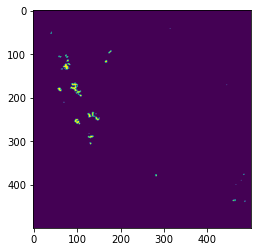

In [15]:
plt.imshow(result<100)
# plt.axis('off')
# plt.colorbar() 

plt.show()
plt.close()

In [9]:
result

array([[100., 100., 100., ..., 100., 100., 100.],
       [200., 200., 100., ..., 200., 200., 200.],
       [200., 200., 100., ..., 200., 200., 200.],
       ...,
       [150., 150., 150., ..., 100., 100., 100.],
       [150., 150., 150., ..., 100., 100., 100.],
       [150., 150., 150., ..., 100., 100., 100.]], dtype=float32)

In [10]:
def find_npy_file(path, file, band):
    """
    Returns the string name of another file from the same time for a given GOES band npy file,
    or None if there is no such file in the given directory.
    
    Parameter path: The path where the returned file is located in
    Precondition: path is a string to a directory relative to the current one, with .npy files
    
    Parameter file: A file from the same time the returned file should have
    Precondition: file is a string with the name of the original file, and includes the path
    
    Parameter band: GOES band the returned file should be from
    Precondition: band is a string of length 2
    """
    for x in os.listdir(path):
        if x[19:21] == band and file[23:37] == x[27:41]:
            return x

def fire_mask(img07, img14):
    m = (330-210)/(340-295)
    b = 210 - m*295
    return (img14) < (m*img07 + b)

In [11]:
mean = []
std = []

path = '../../GOES_Files/npy_files/'
pathCM = '../../GOES_Files/clear_sky_mask/'

for file in os.listdir(pathCM):
    if file[23:37] == firefile[23:37]:
        CM = file

file07 = find_npy_file('../../GOES_Files/npy_files', CM, '07')
file14 = find_npy_file('../../GOES_Files/npy_files', CM, '14')

img07 = np.load(path + file07)
img14 = np.load(path + file14)

cloud_mask = np.load(pathCM + CM)
cloud_mask = cloud_mask.astype(bool)

fires = np.logical_and(fire_mask(img07, img14), np.logical_not(cloud_mask))

/sharedData2/nshakoor/.conda/envs/fires/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  # Remove the CWD from sys.path while we load stuff.


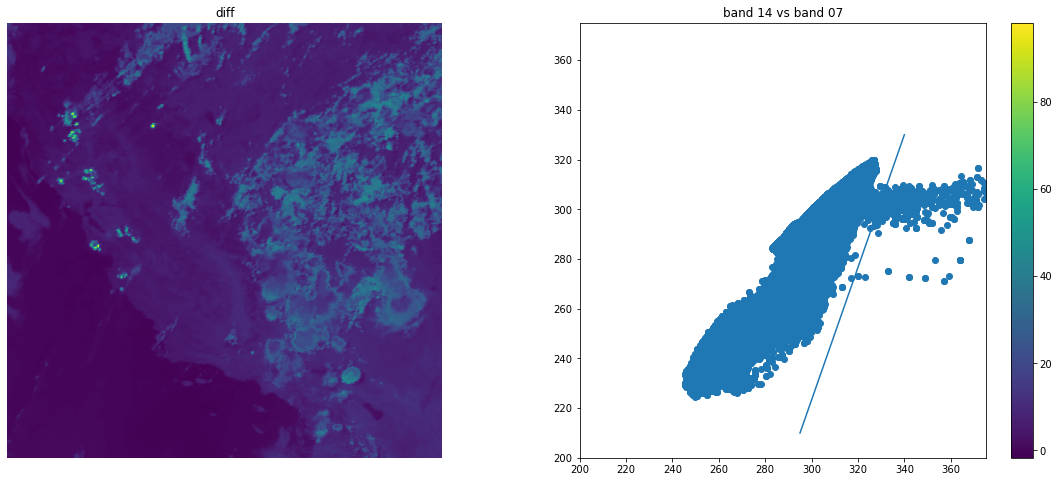

In [12]:
graph_min = 200
graph_max = 375

fig, ax = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1]})

diff = img07 - img14
im = ax[0].imshow(diff, aspect='equal')
ax[0].set_title('diff')
ax[0].axis('off')
fig.colorbar(im)

ax[1].scatter(img07, img14)
ax[1].plot([295, 340], [210, 330], label='fires')
ax[1].set_xlim([graph_min, graph_max])
ax[1].set_ylim([graph_min, graph_max])
ax[1].set_title('band 14 vs band 07')

plt.show()